In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
#kinematic viscosity curve fit:
dataframe = pd.read_csv("./data/models_data/Viscosity_data.csv",sep=";")
dataframe = dataframe[["emp. [°C]","Kin. Viscosity [mm²/s]","Density [g/cm³]"]].dropna()
poly = np.polyfit(dataframe["emp. [°C]"],dataframe["Kin. Viscosity [mm²/s]"], deg=5)
print(np.polyval(poly, 13.1795)) #returns the v (kinematic viscosity of water) of 5C°

1.1953406700143954


In [4]:
LakeAegeri= pd.read_csv(r".\data\cleaned_data\230422\230422_LakeAegeri_3A.csv")
try:
    LakeAegeri=LakeAegeri.drop(["Unnamed: 0"], axis=1)
except:
    pass
LakeAegeri["datetime"] = pd.to_datetime(LakeAegeri["datetime"])
LakeAegeri.columns

Index(['x', 'datetime', 'bulk_temp', 'skin_temp', 'air_temp', 'wind_speed',
       'air_pressure', 'relative_humidity', 'solar_irradiance',
       'meteo_timestamp', 'Quality'],
      dtype='object')

In [5]:
LakeAegeri["Conductivity"]=172#we dont have the data here. later...
LakeAegeri.head()

def skin_effect(dataframe,column_watertemp,column_windspeed,column_solar_irradiance,column_conductivity,variance=6):
    #see above
    dataframe_viscos = pd.read_csv("./data/models_data/Viscosity_data.csv",sep=";")
    dataframe_viscos = dataframe_viscos[["emp. [°C]","Kin. Viscosity [mm²/s]","Density [g/cm³]"]].dropna()
    poly = np.polyfit(dataframe_viscos["emp. [°C]"],dataframe_viscos["Kin. Viscosity [mm²/s]"], deg=5)

    dataframe["kin_Viscosity"]= np.polyval(poly,dataframe[column_watertemp])
    #thikness_of_molecular_sublayer=(variance*dataframe["kin_Viscosity"])/dataframe[column_windspeed]


    delta_t=(variance*dataframe[column_solar_irradiance]*dataframe["kin_Viscosity"])/(dataframe[column_conductivity]*dataframe[column_windspeed])
    return pd.concat([pd.DataFrame(delta_t),dataframe],axis=1).rename(columns={0: "Skin_effect"})

result = skin_effect(dataframe=LakeAegeri,column_watertemp="bulk_temp",variance=4,column_windspeed="wind_speed",column_solar_irradiance="solar_irradiance",column_conductivity="Conductivity")

In [6]:
result.columns


Index(['Skin_effect', 'x', 'datetime', 'bulk_temp', 'skin_temp', 'air_temp',
       'wind_speed', 'air_pressure', 'relative_humidity', 'solar_irradiance',
       'meteo_timestamp', 'Quality', 'Conductivity', 'kin_Viscosity'],
      dtype='object')

In [31]:
#Test the model:
result["Skin_effect_real"]=(result["bulk_temp"]-result["skin_temp"]).abs()

display(result["Skin_effect"].describe())
display(result["Skin_effect_real"].describe())

count    14991.000000
mean         1.048880
std          2.725719
min          0.000000
25%          0.000000
50%          0.006085
75%          0.723538
max         48.991702
Name: Skin_effect, dtype: float64

count    14991.000000
mean         1.509172
std          1.213359
min          0.000077
25%          0.622952
50%          1.294452
75%          2.009072
max          9.495047
Name: Skin_effect_real, dtype: float64

100


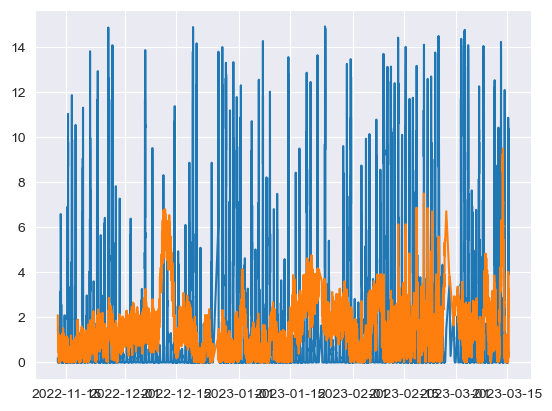

In [32]:
count = result[result["Skin_effect"] > 15]
print(len(count))
result = result.loc[result["Skin_effect"] < 15 ]

plt.plot(result["datetime"],result["Skin_effect"])
plt.plot(result["datetime"],result["Skin_effect_real"])

In [33]:
result["Skin_effect_real_diff"]=(result["Skin_effect"]-result["Skin_effect_real"]).abs()
result["Skin_effect_real_diff"].describe()

count    14891.000000
mean         1.683267
std          1.729695
min          0.000015
25%          0.584882
50%          1.253531
75%          2.057961
max         14.067958
Name: Skin_effect_real_diff, dtype: float64